In [1]:
import os, glob
import numpy as np
import dicom as di
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

# 3D Affine Formulae
---
\begin{align}
\mathbf{A}_{multi} = \begin{vmatrix}
F_{11}\Delta_r & F_{12}\Delta_c & \frac{T_1^1-T_1^N}{1-N} & T_1^1 \\
F_{21}\Delta_r & F_{22}\Delta_c & \frac{T_2^1-T_2^N}{1-N} & T_2^1 \\
F_{31}\Delta_r & F_{32}\Delta_c & \frac{T_3^1-T_3^N}{1-N} & T_3^1 \\
0 & 0 & 0 & 1
\end{vmatrix}
\end{align}

- $F_{ij}$ : ImageOrientationPatient 정보 
    - ($i_1$, $i_2$, $i_3$, $i_4$, $i_5$, $i_6$) = ($F_{12}$, $F_{22}$, $F_{32}$, $F_{11}$, $F_{21}$, $F_{31}$)  
    
- $\Delta_r$ : Row spacing

- $\Delta_c$ : Col spacing

- $T_1$ : 첫번째 DICOM 의 ImagePositionPatient 정보
    - (X, Y, Z) 형식

- $T_N$ : 마지막 DICOM 의 ImagePositionPatient 정보
    - (X, Y, Z) 형식
    
- $1-N$ : 1 - DICOM 갯수

# CSV 정보
---
- $(X_{csv}, Y_{csv}, Z_{csv}, 1) = A_{multi} * (X,Y,Z,1)$

- labeling 할때는 $(X,Y,Z,1) = inv(A_{multi}) * (X_{csv}, Y_{csv}, Z_{csv}, 1)$ 해줘야함.

In [2]:
def make_affine_matrix(dcm_paths):
    
    '''
    input 
        - dcm_paths : DICOM files paths
        
    output
        - 3D Affine Formulae
    '''
    
    tmp=di.read_file(dcm_paths[0])
    '''
    A1 = np.zeros([4,4])
    A1[:3, 0] = np.array(tmp.ImageOrientationPatient)[3:]
    A1[:3, 1] = np.array(tmp.ImageOrientationPatient)[:3]
    A1[:3, 3] = np.array(tmp.ImagePositionPatient)
    A1[-1,-1] = 1
    '''
    T1 = np.array(tmp.ImagePositionPatient)
    
    tmp = di.read_file(dcm_paths[-1])
    '''
    AN = np.zeros([4,4])
    AN[:3, 0] = np.array(tmp.ImageOrientationPatient)[3:]
    AN[:3, 1] = np.array(tmp.ImageOrientationPatient)[:3]
    AN[:3, 3] = np.array(tmp.ImagePositionPatient)
    AN[-1,-1] = 1
    '''
    TN = np.array(tmp.ImagePositionPatient)
    
    spacing = tmp.PixelSpacing
    
    AM = np.zeros([4,4])
    AM[-1,-1] = 1
    AM[:3, 0] = np.array(tmp.ImageOrientationPatient)[3:]*spacing[0]
    AM[:3, 1] = np.array(tmp.ImageOrientationPatient)[:3]*spacing[1]
    AM[:3, 2] = np.reshape((T1-TN)/(1-len(dcm_paths)), (-1))[:3]
    AM[:3, 3] = np.reshape(T1[:3], -1)
    
    return AM

In [40]:
num_path = os.listdir('./data/')
num_path.pop(0)
print(num_path)

data_path = os.listdir('./data/'+num_path[0])
print(data_path)
dcm_paths = glob.glob('./data/%s/%s/*.dcm'%(num_path[0],data_path[3]))
print(len(dcm_paths))

['01', '02', '03']
['12575', '12653', '12692', '12803', '12841']
160


In [41]:
# Make image data

img = []
for idx, path in enumerate(dcm_paths):
    tmp = di.read_file(path)
    img.append(tmp.pixel_array)
img = np.array(img)

In [42]:
# Make coordinate data

csv_path = glob.glob('./data/%s/%s/*.csv'%(num_path[0],data_path[3]))
coor_csv = []
for i in csv_path:
    csv = pd.read_csv(i)
    for idx, val in csv.iterrows():
        coor_csv.append(np.array([[val['X']],[val['Y']],[val['Z']],[1.]]))

coor_csv = np.reshape(np.array(coor_csv), [-1,4])
coor_csv = np.transpose(coor_csv, [1,0])

In [43]:
# Make affine matrix and inverse matrix

AM = make_affine_matrix(dcm_paths)

inv_AM = np.linalg.inv(AM)

In [44]:
# Compute original coordinate

ori_coor=np.uint(np.matmul(inv_AM, coor_csv))

In [45]:
# Make label data

ground = np.zeros(img.shape)
for i in range(len(ori_coor[0])):
    ground[ori_coor[2,i], ori_coor[0,i], ori_coor[1,i]]=1000


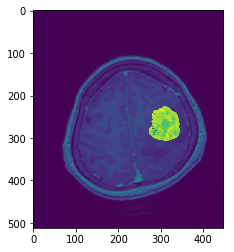

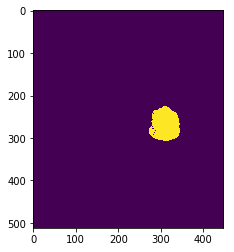

In [54]:
num =np.uint(np.mean(ori_coor[2]))
plt.imshow(img[num]+ground[num])
plt.show()
plt.figure()
plt.imshow(ground[num])
plt.show()